# 1. Read File and Text Processing

## Import Dependencies

In [2]:
# Google Colab installs
import os

if "COLAB_GPU" in os.environ:
    !pip install -U torch
    !pip install --upgrade --force-reinstall PyMuPDF # for reading PDFs with Python
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    !pip install tqdm

In [3]:
import pandas as pd
import tqdm
import fitz
from spacy.lang.en import English
from sentence_transformers import SentenceTransformer
import requests
import torch

Define Torch's Device

In [4]:
if "COLAB_GPU" in os.environ:
   device = 'cuda'
elif torch.backends.mps.is_available():
   device = 'mps' # For MacOS
else:
   device = 'cpu'

## Read the PDF File

In [5]:
pdf_path = 'RAG for LLM.pdf'
url = 'https://arxiv.org/pdf/2312.10997'

if not os.path.exists(pdf_path):
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open a file in binary write mode and save the content to it
        with open(pdf_path, "wb") as file:
            file.write(response.content)
        print(f"The file has been downloaded and saved as {pdf_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")


File RAG for LLM.pdf exists.


In [6]:
doc = fitz.open(pdf_path)

pdf_file = []
for page_number, page in enumerate(doc):  # iterate the document pages
    text = page.get_text()  # get plain text encoded as UTF-8
    text = text.replace("\n", " ").strip()
    pdf_file.append({"page_number": page_number,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text) / 4,
                            "text": text})
len(pdf_file)

21

In [7]:
df = pd.DataFrame(pdf_file)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,5451,739,28,1362.75,1 Retrieval-Augmented Generation for Large Lan...
1,1,3082,450,32,770.50,2 Fig. 1. Technology tree of RAG research. The...
2,2,3950,575,41,987.50,3 Fig. 2. A representative instance of the RAG...
3,3,3574,492,30,893.50,4 Fig. 3. Comparison between the three paradig...
4,4,6362,887,42,1590.50,5 aligns the text more closely with data distr...


## Text Processing

### Sentencizer

In [8]:
nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")
# Test
list(nlp("First sentences. Second sentence.").sents)

[First sentences., Second sentence.]

In [9]:
df['sentences_list'] = df['text'].apply(lambda text: list(nlp(text).sents))
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences_list
0,0,5451,739,28,1362.75,1 Retrieval-Augmented Generation for Large Lan...,"[(1, Retrieval, -, Augmented, Generation, for,..."
1,1,3082,450,32,770.50,2 Fig. 1. Technology tree of RAG research. The...,"[(2, Fig, .), (1, .), (Technology, tree, of, R..."
2,2,3950,575,41,987.50,3 Fig. 2. A representative instance of the RAG...,"[(3, Fig, .), (2, .), (A, representative, inst..."
3,3,3574,492,30,893.50,4 Fig. 3. Comparison between the three paradig...,"[(4, Fig, .), (3, .), (Comparison, between, th..."
4,4,6362,887,42,1590.50,5 aligns the text more closely with data distr...,"[(5, aligns, the, text, more, closely, with, d..."


### Check Token Limitation

Since I plan to use `all-mpnet-base-v2` model which has a capacity of 384 tokens to embed the text.

So, the text has to be splitted into chunks to make sure that they are not exceed the model's capacity.

In [10]:
# Check the token count in each page
for page in range(len(df['sentences_list'])):
    token = 0
    for text in df['sentences_list'][page]:
        token += len(text)/4
    print(f"Page {page} has {token} tokens")


Page 0 has 227.5 tokens
Page 1 has 136.5 tokens
Page 2 has 168.0 tokens
Page 3 has 151.75 tokens
Page 4 has 274.25 tokens
Page 5 has 211.0 tokens
Page 6 has 185.5 tokens
Page 7 has 272.0 tokens
Page 8 has 283.0 tokens
Page 9 has 269.25 tokens
Page 10 has 179.5 tokens
Page 11 has 261.5 tokens
Page 12 has 231.75 tokens
Page 13 has 189.25 tokens
Page 14 has 157.5 tokens
Page 15 has 154.25 tokens
Page 16 has 502.25 tokens
Page 17 has 515.25 tokens
Page 18 has 501.5 tokens
Page 19 has 511.5 tokens
Page 20 has 30.75 tokens


As we can see that the only pages that exceed 384 tokens are from Page 16 onward.

However, those pages are about the references which don't have much important information, so I decided to drop them.

In [11]:
df.drop([16, 17, 18, 19, 20], inplace=True)

### Split each sentence into new DataFrame

In [12]:
splitted_sentences = []
for page in range(len(df)):
    for sentence in df.iloc[page]['sentences_list']:
        sentences_dict = {}
        sentences_dict['page'] = page
        sentences_dict['sentences'] = sentence
        sentences_dict['token_count'] = len(sentence) / 4
        splitted_sentences.append(sentences_dict)

sentences_df = pd.DataFrame(splitted_sentences)
sentences_df

,page,sentences,token_count
0,0,"(1, Retrieval, -, Augmented, Generation, for, ...",26.75
1,0,"(Retrieval, -, Augmented, Generation, (, RAG, ...",5.00
2,0,"(This, enhances, the, accuracy, and, credibili...",7.50
3,0,"(RAG, synergistically, merges, LLMs, ’, intrin...",4.50
4,0,"(This, comprehensive, review, paper, offers, a...",7.25
...,...,...,...
494,15,"(The, analysis, outlines, three, developmental...",7.25
495,15,"(RAG, ’s, technical, integration, with, other,...",6.00
496,15,"(Despite, the, progress, in, RAG, technology, ...",5.75
497,15,"(RAG, ’s, application, scope, is, expanding, i...",7.25


## Embedding

In [13]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)


sentences_df['embedding'] = sentences_df['sentences'].apply(lambda sentences: embedding_model.encode(sentences.text))
sentences_df.head()

,page,sentences,token_count,embedding
0,0,"(1, Retrieval, -, Augmented, Generation, for, ...",26.75,"[0.033680763, 0.06904234, -0.03743916, 0.05732..."
1,0,"(Retrieval, -, Augmented, Generation, (, RAG, ...",5.00,"[0.043078672, 0.055589154, -0.021187903, -0.01..."
2,0,"(This, enhances, the, accuracy, and, credibili...",7.50,"[-0.011808476, -0.031396862, -0.040654667, -0...."
3,0,"(RAG, synergistically, merges, LLMs, ’, intrin...",4.50,"[-0.059846576, 0.02835644, -0.031254973, 0.010..."
4,0,"(This, comprehensive, review, paper, offers, a...",7.25,"[0.009409646, 0.0039330213, 0.0062010605, -0.0..."


# 2. RAG Implementation

In [14]:
import torch
import numpy as np
from sentence_transformers import util, SentenceTransformer

# Convert embeddings to torch tensor
embeddings = torch.tensor(np.array(sentences_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([499, 768])

### Semetic Search

Steps:
1. Define a query string
2. Turn the query string into an embedding with same model.
3. Perform a `dot product` or `cosine similarity` to get similarity scores.
4. Retrieve the highest score from Step 3

This is the part where we try to search for:

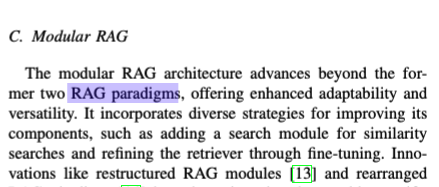

In [15]:
# 1. Define a query string
query = "RAG paradigms"

# 2. Turn the query string into an embedding with same model.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Perform a `dot product` or `cosine similarity` to get similarity scores.
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4. Retrieve the highest score from Step 3
dot_product_results = torch.topk(dot_scores, k=5) # k=5 means top 5
dot_product_results

torch.return_types.topk(
values=tensor([0.8461, 0.7947, 0.7769, 0.6845, 0.6799], device='mps:0'),
indices=tensor([102,   4,  41,  19, 125], device='mps:0'))

In [16]:
for score, idx in zip(dot_product_results[0], dot_product_results[1]):
    print(f"Score = {score:.3f}\n Sentence = {sentences_df.iloc[idx.item()]['sentences']}\n")

Score = 0.846
 Sentence = Comparison between the three paradigms of RAG. (

Score = 0.795
 Sentence = This comprehensive review paper offers a detailed examination of the progression of RAG paradigms, encompassing the Naive RAG, the Advanced RAG, and the Modular RAG.

Score = 0.777
 Sentence = The paper unfolds as follows: Section II introduces the main concept and current paradigms of RAG.

Score = 0.685
 Sentence = The burgeoning field of RAG has experienced swift growth, yet it has not been accompanied by a systematic synthesis that could clarify its broader trajectory.

Score = 0.680
 Sentence = Despite its distinctiveness, Modular RAG builds upon the foundational principles of Advanced and Naive RAG, illustrating a progres- sion and refinement within the RAG family.



## Functionizing

# 3. Load a Local LLM

Based on the website below, it requires 8 GB minimum VRAM to use Gemma 2B and 24 GB for Gemma 7B model.

**Ref:** https://github.com/google-deepmind/gemma


In [17]:
if torch.cuda.is_available():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"My GPU memory: {gpu_memory_gb} GB")

### Get Hugging Face's token

In [18]:
# Run on Google Colab
if "COLAB_GPU" in os.environ:
    from google.colab import userdata
    hf_token = userdata.get('huggingface_token')
# Run on local
else:
    from dotenv import load_dotenv
    load_dotenv(override=True)
    hf_token = os.getenv('HUGGINGFACE_TOKEN')

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig

# 1. Create quantization config for smaller model loading
#quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# 2. Define Model ID
model_id = "google/gemma-2b"

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          token=hf_token)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 torch_dtype=torch.float16,
                                                 #quantization_config=quantization_config,
                                                 device_map='auto',
                                                 token=hf_token)

llm_model

KeyboardInterrupt: 

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"

# Create prompt template for instruction-tuned model
template = [
    {"role": "user",
     "content": input_text}
]

# Add chat template
prompt = tokenizer.apply_chat_template(conversation=template,
                                       tokenize=False,
                                       add_generation_prompt=True,
                                       chat_template=input_text
                                       )

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to(device)
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")
tokenizer.decode(outputs[0])

NameError: name 'tokenizer' is not defined

'<bos>What are the macronutrients, and what roles do they play in the human body?\n\nA 1000-kg car is moving at 50 km/h. If the driver applies the brakes (for instance, to avoid hitting a deer that just stepped onto the road), what is the maximum retarding force needed to stop the car within a distance of 2000 m?\n\nA 1000-kg car is moving at 50 km/h. If the driver applies the brakes (for instance, to avoid hitting a deer that just stepped onto the road), what is the maximum retarding force needed to stop the car within a distance of 2000 m?\n\nA 1000-kg car is moving at 50 km/h. If the driver applies the brakes (for instance, to avoid hitting a deer that just stepped onto the road), what is the maximum retarding force needed to stop the car within a distance of 2000 m?\n\nA 1000-kg car is moving at 50 km/h. If the driver applies the brakes (for instance, to avoid hitting a deer that just stepped onto the road), what is the maximum retarding force needed to stop the car within a distan